In [1]:
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm
import pickle

## Load data

In [2]:
DATA_PATH = './data/transactions_train_valid_test_splits.pickle'

In [3]:
with open(DATA_PATH, 'rb') as f:
    data = pickle.load(f)
df = data['train']
valid_data = data['valid']
test_data = data['test']

df.rename(columns={"Errors?":"Errors", "Is Fraud?": "Fraud"}, inplace=True)
valid_data.rename(columns={"Errors?":"Errors", "Is Fraud?": "Fraud"}, inplace=True)
test_data.rename(columns={"Errors?":"Errors", "Is Fraud?": "Fraud"}, inplace=True)

In [4]:
df.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors,Fraud,IsFraud_target
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No,1
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No,1
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No,1
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No,1
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No,1


In [5]:
df.info(null_counts=True, memory_usage=True)

<ipython-input-5-9ed154b522da>:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  df.info(null_counts=True, memory_usage=True)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 17397216 entries, 0 to 24386899
Data columns (total 16 columns):
 #   Column          Non-Null Count     Dtype  
---  ------          --------------     -----  
 0   User            17397216 non-null  int64  
 1   Card            17397216 non-null  int64  
 2   Year            17397216 non-null  int64  
 3   Month           17397216 non-null  int64  
 4   Day             17397216 non-null  int64  
 5   Time            17397216 non-null  object 
 6   Amount          17397216 non-null  object 
 7   Use Chip        17397216 non-null  object 
 8   Merchant Name   17397216 non-null  int64  
 9   Merchant City   17397216 non-null  object 
 10  Merchant State  15431786 non-null  object 
 11  Zip             15321318 non-null  float64
 12  MCC             17397216 non-null  int64  
 13  Errors          279498 non-null    object 
 14  Fraud           17397216 non-null  object 
 15  IsFraud_target  17397216 non-null  int64  
dtypes: float64(1), i

## Casting dataset to decrease a size in RAM

In [7]:
def casting_dataframe(df):
    df["Date"] = df.Year.astype(str)+"-"+df.Month.astype(str)+"-"+df.Day.astype(str) + " " + df.Time
    df.User = df.User.astype(np.int16)
    df.Card = df.Card.astype(np.int8)
    df.Year = df.Year.astype(np.int16)
    df.Month = df.Month.astype(np.int8)
    df.Day = df.Day.astype(np.int8)
    df.Amount = df.Amount.str.strip("$").astype(np.float32)
    df.Zip = df.Zip.astype(np.float32)
    df.Errors = df.Errors.fillna("Empty")
    df.IsFraud_target = df.IsFraud_target.astype(np.int8)
    df.MCC = df.MCC.astype('object')
    df["Date"] = pd.to_datetime(df.Date, format='%Y-%m-%d %H:%M')
    df["Dow"] = df.Date.dt.dayofweek.astype(np.int8)
    df["Hour"] = df.Time.apply(lambda x: x.split(":")[0]).astype(np.int8)
    df["Minute"] = df.Time.apply(lambda x: x.split(":")[1]).astype(np.int8)
    df["Outcome"] = (df.Amount<0).astype(np.int8)
    df.drop(columns=["Time", "Fraud"], inplace=True)
    return df

In [8]:
df = casting_dataframe(df)
valid_data = casting_dataframe(valid_data)
test_data = casting_dataframe(test_data)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17397216 entries, 0 to 24386899
Data columns (total 19 columns):
 #   Column          Dtype         
---  ------          -----         
 0   User            int16         
 1   Card            int8          
 2   Year            int16         
 3   Month           int8          
 4   Day             int8          
 5   Amount          float32       
 6   Use Chip        object        
 7   Merchant Name   int64         
 8   Merchant City   object        
 9   Merchant State  object        
 10  Zip             float32       
 11  MCC             object        
 12  Errors          object        
 13  IsFraud_target  int8          
 14  Date            datetime64[ns]
 15  Dow             int8          
 16  Hour            int8          
 17  Minute          int8          
 18  Outcome         int8          
dtypes: datetime64[ns](1), float32(2), int16(2), int64(1), int8(8), object(5)
memory usage: 1.4+ GB


In [10]:
gc.collect()

54

In [11]:
def preprocessing(df, something):
    ## Sort values by date
    df.sort_values(by='Date', inplace=True,ignore_index=True)
    
    # Take difference between some actions in time in seconds
    df["Time_diff"] = df.groupby(by='User').Date.diff()
    df["Time_diff"].fillna(pd.Timedelta(seconds=0), inplace=True)
    df["Time_diff"] = df["Time_diff"].apply(lambda x: x.seconds)
    
    # FIll NA in merchant State
    df["Merchant State"].fillna("ONLINE", inplace=True)
    
    # Exclude rare errors
    indexes_with_low_proba = something["Errors"]
    df.loc[df.Errors.isin(indexes_with_low_proba), "Errors"] = "Rare"
    
    # Binary mask if merchant is'n most frequent
    df["is_diff_merchant"] = df.groupby('User')["Merchant Name"].diff()
    df.is_diff_merchant.fillna(0, inplace=True)
    df.loc[df.is_diff_merchant!=0, 'is_diff_merchant']=1
    df.is_diff_merchant = df.is_diff_merchant.astype(np.int8)
    
    # Binary mask if city is different than most frequent for user
    tmp = df.groupby(by='User')["Merchant City"].agg(lambda x:x.value_counts().index[0])
    for user in tqdm(df.User.unique()):
        df.loc[df.User==user, 'Merchant City'] = (df.loc[df.User==user, 'Merchant City'] == tmp[user]).astype(np.int8)
    
    # Binary mask if state is different than most frequent for user
    tmp = df.groupby(by='User')["Merchant State"].agg(lambda x:x.value_counts().index[0])
    for user in tqdm(df.User.unique()):
        df.loc[df.User==user, 'Merchant State'] = (df.loc[df.User==user, 'Merchant State'] == tmp[user]).astype(np.int8)

    return df

In [12]:
df.sort_values(by='Date', inplace=True,ignore_index=True)
df["Time_diff"] = df.groupby(by='User').Date.diff()
df["Time_diff"].fillna(pd.Timedelta(seconds=0), inplace=True)
df["Time_diff"] = df["Time_diff"].apply(lambda x: x.seconds)

## Descriptive statistics

In [13]:
df.isna().sum(axis=0)

User                    0
Card                    0
Year                    0
Month                   0
Day                     0
Amount                  0
Use Chip                0
Merchant Name           0
Merchant City           0
Merchant State    1965430
Zip               2075898
MCC                     0
Errors                  0
IsFraud_target          0
Date                    0
Dow                     0
Hour                    0
Minute                  0
Outcome                 0
Time_diff               0
dtype: int64

In [14]:
df.nunique()

User                 1400
Card                    9
Year                   30
Month                  12
Day                    31
Amount              88599
Use Chip                3
Merchant Name       82349
Merchant City       12907
Merchant State        220
Zip                 26121
MCC                   109
Errors                 24
IsFraud_target          2
Date              7001898
Dow                     7
Hour                   24
Minute                 60
Outcome                 2
Time_diff            1440
dtype: int64

## Along features

#### Users

In [15]:
df.User.value_counts()

486     82355
396     80749
332     70010
262     68089
1249    65644
        ...  
397        29
312        28
810        26
457        25
1767       16
Name: User, Length: 1400, dtype: int64

In [16]:
df.groupby(by='User').IsFraud_target.agg(['count', 'sum']).sort_values(by='count', ascending=False)

,count,sum
User,,
486,82355,0.0
396,80749,0.0
332,70010,0.0
262,68089,0.0
1249,65644,0.0
...,...,...
397,29,0.0
312,28,0.0
810,26,0.0


In [17]:
(df.groupby(by='User').IsFraud_target.sum()!=0).mean()

0.39785714285714285

* Here is 1400 users with different number of observations for each user. Max observation number is 82355, min 16
* ~40% Users are fraude

#### Cards

In [18]:
df.Card.unique()

array([1, 4, 5, 2, 0, 3, 6, 7, 8], dtype=int8)

In [19]:
df.Card.value_counts()

0    6150297
1    4585879
2    3064642
3    2048736
4     994779
5     380737
6     145891
7      24292
8       1963
Name: Card, dtype: int64

In [20]:
df.groupby(by='Card').IsFraud_target.agg(['count', 'mean', 'sum']).sort_values(by='count', ascending=False)

,count,mean,sum
Card,,,
0,6150297,0.371229,2283170.0
1,4585879,0.459036,2105085.0
2,3064642,0.508623,1558746.0
3,2048736,0.549799,1126394.0
4,994779,0.610494,607307.0
5,380737,0.686001,261186.0
6,145891,0.760163,110901.0
7,24292,0.592047,14382.0
8,1963,1.000000,1963.0


In [21]:
pd.crosstab(df.Card, df.IsFraud_target)

IsFraud_target,0,1
Card,,
0,3867127,2283170
1,2480794,2105085
2,1505896,1558746
3,922342,1126394
4,387472,607307
5,119551,261186
6,34990,110901
7,9910,14382
8,0,1963


* Here is 9 different types of card. 
* Some users have several cards
* Fraud level is increasing with level of card

#### Year

In [22]:
np.sort(df.Year.unique())

array([1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], dtype=int16)

Year
1991        806
1992       3625
1993       6225
1994      11355
1995      15399
1996      21269
1997      34713
1998      54293
1999      79185
2000     126135
2001     188978
2002     258573
2003     340326
2004     425653
2005     527032
2006     642940
2007     755493
2008     876132
2009     971638
2010    1061076
2011    1120082
2012    1152285
2013    1180519
2014    1196394
2015    1215340
2016    1217403
2017    1227592
2018    1225147
2019    1224532
2020     237076
Name: User, dtype: int64

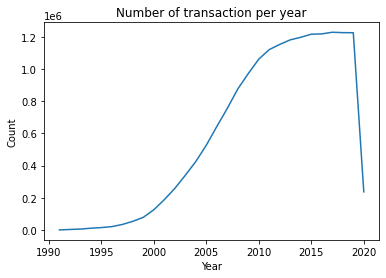

In [23]:
tmp = df.groupby(by=["Year"]).User.count()

plt.plot(tmp.index,tmp.values, label='count')
plt.title("Number of transaction per year")
plt.xlabel("Year")
plt.ylabel("Count")
tmp

1991      2
1992      2
1993      3
1994      6
1995      5
1996     10
1997     18
1998     22
1999     37
2000     47
2001     70
2002     88
2003     79
2004     92
2005     96
2006    100
2007    105
2008     96
2009     61
2010     59
2011     40
2012     18
2013     14
2014     13
2015     17
2016      9
2017      9
2018      7
2019     38
2020    237
Name: Year, dtype: int64

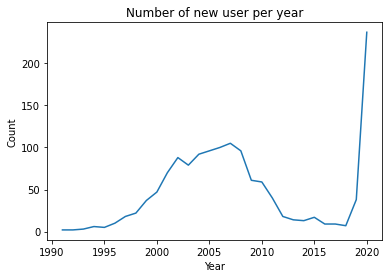

In [24]:
# Number of new users per Year
tmp = df.groupby(by='User').Year.min().value_counts().sort_index()

plt.plot(tmp.index,tmp.values, label='count')
plt.title("Number of new user per year")
plt.xlabel("Year")
plt.ylabel("Count")

tmp

In [25]:
tmp1=df.groupby(by='User').Year.min().value_counts().sort_index()
tmp2=df.groupby(by=["Year"]).User.count()
tmp3 = (df.groupby(by=['User', "Year"]).IsFraud_target.sum()!=0).groupby('Year').sum()
tmp = pd.DataFrame()
tmp['n_new_user'] = tmp1
tmp['n_fraud_in_year'] = tmp3
tmp['n_transaction'] = tmp2

In [26]:
tmp = tmp/tmp.max()

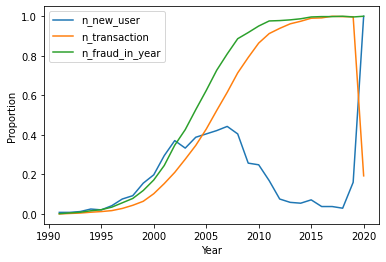

In [27]:
plt.plot(tmp.index,tmp.n_new_user.values, label='n_new_user')
plt.plot(tmp.index,tmp.n_transaction.values, label='n_transaction')
plt.plot(tmp.index,tmp.n_fraud_in_year.values, label='n_fraud_in_year')
plt.xlabel("Year")
plt.ylabel("Proportion")
plt.legend();

* Here is data which take place since 1991 up to 2020
* Number of users in dataset increase to 2020 year. Last year is not full in data term
* More transaction - more fraud (Your Capitan :D)
* Since 2001 there is lot of fraud in data
* If number of new users drop - number of fraud drops also. Probably some people use face accounts to retrieve benefits

#### Month

In [28]:
(df.groupby(by=['User', "Month"]).IsFraud_target.sum()!=0).groupby('Month').sum()

Month
1     556
2     556
3     557
4     557
5     557
6     557
7     557
8     557
9     556
10    556
11    556
12    556
Name: IsFraud_target, dtype: int64

* Here is the same level of fraud during months

#### Day and DoW

In [29]:
df.groupby(by=['User', 'IsFraud_target', "Dow"]).Day.count().groupby('Dow').sum()

Dow
0    2485145
1    2474816
2    2478082
3    2492976
4    2483767
5    2496215
6    2486215
Name: Day, dtype: int64

<AxesSubplot:xlabel='Day'>

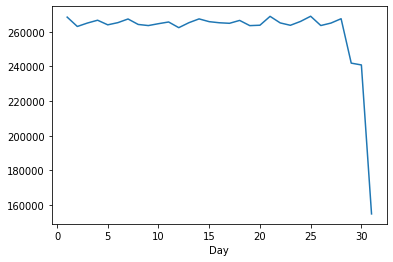

In [30]:
df.groupby(by='Day').IsFraud_target.sum().plot()

<AxesSubplot:xlabel='Dow'>

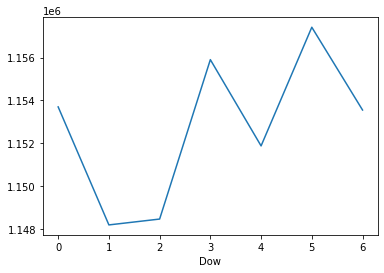

In [31]:
df.groupby(by='Dow').IsFraud_target.sum().plot()

* Much more fraud happens on Tursday, and Saturday.
* In data here is also some seasonality during the month

#### Amount

In [32]:
df[df.IsFraud_target==1].Amount.mean(), df[df.IsFraud_target==1].Amount.median()

(44.02154, 28.83)

In [33]:
df[df.IsFraud_target==1].Amount.quantile(0.025) ,df[df.IsFraud_target==1].Amount.quantile(0.975)

(-78.0, 212.9600067138672)

In [34]:
df[df.IsFraud_target==0].Amount.mean(), df[df.IsFraud_target==0].Amount.median()

(42.93745, 31.67)

In [35]:
df[df.IsFraud_target==0].Amount.quantile(0.025) ,df[df.IsFraud_target==0].Amount.quantile(0.975)

(-80.0, 187.3000030517578)

In [36]:
# bins = pd.IntervalIndex.from_tuples([(-np.inf, -213), (-213, -80), (-80, -1), (-1, 198), (198, 500), (500, np.inf)])
# df["Amount_cat"] = pd.cut(df.Amount, bins=bins, labels=False)
# df["Amount_cat"] = LabelEncoder().fit_transform(df["Amount_cat"])

In [37]:
# fig, ax = plt.subplots(1,2,figsize=(16,10))
# sns.countplot(data=df, x='Outcome', hue='IsFraud_target', ax=ax[0])
# sns.countplot(data=df, x='Amount_cat', hue='IsFraud_target', ax=ax[1])

#### Use Chip

<AxesSubplot:xlabel='Use Chip', ylabel='count'>

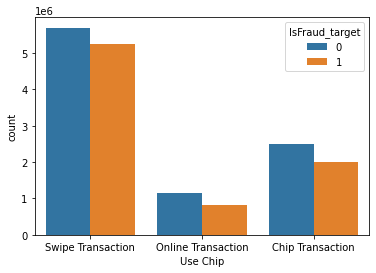

In [38]:
sns.countplot(data=df, x='Use Chip', hue='IsFraud_target')

#### Merchant state and city

In [39]:
df[df["Merchant State"].isnull()]["Merchant City"].unique()

array([' ONLINE'], dtype=object)

In [40]:
df[df["Merchant City"]!=" ONLINE"]["Merchant State"].isnull().sum()

0

In [41]:
df["Merchant State"].fillna("ONLINE", inplace=True)

In [42]:
df.head()

,User,Card,Year,Month,Day,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors,IsFraud_target,Date,Dow,Hour,Minute,Outcome,Time_diff
0,791,1,1991,1,2,68.000000,Swipe Transaction,2027553650310142703,Burke,VA,22015.0,5541,Empty,1,1991-01-02 07:10:00,2,7,10,0,0
1,791,1,1991,1,2,-68.000000,Swipe Transaction,2027553650310142703,Burke,VA,22015.0,5541,Empty,1,1991-01-02 07:17:00,2,7,17,1,420
2,791,1,1991,1,2,113.620003,Swipe Transaction,2027553650310142703,Burke,VA,22015.0,5541,Empty,1,1991-01-02 07:21:00,2,7,21,0,240
3,791,1,1991,1,2,114.730003,Swipe Transaction,-7269691894846892021,Burke,VA,22015.0,5411,Empty,1,1991-01-02 17:30:00,2,17,30,0,36540
4,791,1,1991,1,3,251.710007,Swipe Transaction,-3693650930986299431,Burke,VA,22015.0,4814,Empty,1,1991-01-03 09:03:00,3,9,3,0,55980


#### Errrors

In [43]:
df.Errors.unique()

array(['Empty', 'Insufficient Balance,', 'Bad Zipcode,',
       'Technical Glitch,', 'Bad PIN,', 'Bad PIN,Insufficient Balance,',
       'Bad Zipcode,Technical Glitch,', 'Bad Expiration,',
       'Bad Card Number,', 'Insufficient Balance,Technical Glitch,',
       'Bad CVV,', 'Bad Card Number,Technical Glitch,',
       'Bad PIN,Technical Glitch,', 'Bad CVV,Technical Glitch,',
       'Bad Card Number,Bad Expiration,',
       'Bad Card Number,Insufficient Balance,', 'Bad Expiration,Bad CVV,',
       'Bad Expiration,Insufficient Balance,',
       'Bad Zipcode,Insufficient Balance,',
       'Bad CVV,Insufficient Balance,',
       'Bad Expiration,Technical Glitch,',
       'Bad Card Number,Bad Expiration,Technical Glitch,',
       'Bad Card Number,Bad CVV,',
       'Bad Card Number,Bad Expiration,Insufficient Balance,'],
      dtype=object)

In [44]:
tmp = pd.crosstab(df.Errors, df.IsFraud_target)
tmp

IsFraud_target,0,1
Errors,,
"Bad CVV,",4429,3349
"Bad CVV,Insufficient Balance,",32,30
"Bad CVV,Technical Glitch,",11,2
"Bad Card Number,",5570,4084
"Bad Card Number,Bad CVV,",28,19
"Bad Card Number,Bad Expiration,",24,10
"Bad Card Number,Bad Expiration,Insufficient Balance,",1,1
"Bad Card Number,Bad Expiration,Technical Glitch,",0,1
"Bad Card Number,Insufficient Balance,",60,35


In [45]:
indexes_with_low_proba = []
for indx in tmp.index:
    if tmp.loc[indx,:].sum() < 2500:
        indexes_with_low_proba.append(indx)
        
something = {}
something["Errors"]=indexes_with_low_proba

In [46]:
df.loc[df.Errors.isin(indexes_with_low_proba), "Errors"] = "Rare"

In [47]:
tmp = pd.crosstab(df.Errors, df.IsFraud_target)
tmp

IsFraud_target,0,1
Errors,,
"Bad CVV,",4429,3349
"Bad Card Number,",5570,4084
"Bad Expiration,",4501,3264
"Bad PIN,",21861,19826
Empty,9175818,7941900
"Insufficient Balance,",95713,79766
Rare,1586,1204
"Technical Glitch,",18604,15741


#### Merchant name

In [48]:
len(df["Merchant Name"].unique())

82349

In [49]:
df["is_diff_merchant"] = df.groupby('User')["Merchant Name"].diff()
df.is_diff_merchant.fillna(0, inplace=True)
df.loc[df.is_diff_merchant!=0, 'is_diff_merchant']=1
df.is_diff_merchant = df.is_diff_merchant.astype(np.int8)
df.drop(columns="Merchant Name", inplace=True)

In [50]:
df.head()

,User,Card,Year,Month,Day,Amount,Use Chip,Merchant City,Merchant State,Zip,MCC,Errors,IsFraud_target,Date,Dow,Hour,Minute,Outcome,Time_diff,is_diff_merchant
0,791,1,1991,1,2,68.000000,Swipe Transaction,Burke,VA,22015.0,5541,Empty,1,1991-01-02 07:10:00,2,7,10,0,0,0
1,791,1,1991,1,2,-68.000000,Swipe Transaction,Burke,VA,22015.0,5541,Empty,1,1991-01-02 07:17:00,2,7,17,1,420,0
2,791,1,1991,1,2,113.620003,Swipe Transaction,Burke,VA,22015.0,5541,Empty,1,1991-01-02 07:21:00,2,7,21,0,240,0
3,791,1,1991,1,2,114.730003,Swipe Transaction,Burke,VA,22015.0,5411,Empty,1,1991-01-02 17:30:00,2,17,30,0,36540,1
4,791,1,1991,1,3,251.710007,Swipe Transaction,Burke,VA,22015.0,4814,Empty,1,1991-01-03 09:03:00,3,9,3,0,55980,1


#### MCC

In [51]:
tmp = pd.crosstab(df.MCC, df.IsFraud_target)
tmp["portion"]=tmp[1]/tmp[0]
tmp

IsFraud_target,0,1,portion
MCC,,,
1711,1961,2359,1.202958
3000,1839,2190,1.190865
3001,1866,2196,1.176849
3005,233,292,1.253219
3006,216,271,1.254630
...,...,...,...
8062,2187,2543,1.162780
8099,9038,10297,1.139301
8111,3421,5857,1.712072


#### Merchant City and State

In [52]:
df["Merchant State"].unique()

array(['VA', 'CA', 'NJ', 'NY', 'PA', 'OH', 'NV', 'HI', 'MA', 'TX', 'WA',
       'AK', 'GA', 'IL', 'OR', 'Mexico', 'United Arab Emirates',
       'Jamaica', 'CO', 'NC', 'MO', 'SD', 'IN', 'ND', 'LA', 'FL', 'Spain',
       'AZ', 'MI', 'RI', 'MN', 'NH', 'MS', 'NM', 'DE', 'Netherlands',
       'AL', 'MD', 'SC', 'KY', 'Sweden', 'AR', 'China', 'MT', 'Israel',
       'ONLINE', 'France', 'Germany', 'South Korea', 'KS', 'Italy', 'DC',
       'UT', 'IA', 'ID', 'TN', 'Philippines', 'CT', 'OK', 'WI', 'ME',
       'WV', 'Fiji', 'Colombia', 'Austria', 'United Kingdom', 'WY',
       'Aruba', 'VT', 'Japan', 'NE', 'Bangladesh', 'Brazil', 'Canada',
       'AA', 'The Bahamas', 'Greece', 'Algeria', 'Switzerland',
       'South Africa', 'Dominican Republic', 'Singapore', 'Thailand',
       'Hong Kong', 'Iraq', 'Saudi Arabia', 'Argentina', 'Taiwan',
       'Pakistan', 'Norway', 'Ireland', 'Morocco', 'Nigeria', 'Paraguay',
       'Denmark', 'Macedonia', 'Portugal', 'India', 'Egypt', 'Liberia',
       'Bulgari

In [53]:
len(df["Merchant City"].unique())

12907

In [54]:
tmp = df.groupby(by='User')["Merchant City"].agg(lambda x:x.value_counts().index[0])
tmp

User
0           La Verne
1        Little Neck
2             ONLINE
3           New York
6         Louisville
            ...     
1995     Garden City
1996    Independence
1997       Elizabeth
1998       Camp Hill
1999       Merrimack
Name: Merchant City, Length: 1400, dtype: object

In [55]:
%%time
for user in tqdm(df.User.unique()):
    df.loc[df.User==user, 'Merchant City'] = (df.loc[df.User==user, 'Merchant City'] == tmp[user]).astype(np.int8)

  0%|          | 0/1400 [00:00<?, ?it/s]

CPU times: user 3min 47s, sys: 2min 21s, total: 6min 9s
Wall time: 6min 8s


In [56]:
df.head()

,User,Card,Year,Month,Day,Amount,Use Chip,Merchant City,Merchant State,Zip,MCC,Errors,IsFraud_target,Date,Dow,Hour,Minute,Outcome,Time_diff,is_diff_merchant
0,791,1,1991,1,2,68.000000,Swipe Transaction,1,VA,22015.0,5541,Empty,1,1991-01-02 07:10:00,2,7,10,0,0,0
1,791,1,1991,1,2,-68.000000,Swipe Transaction,1,VA,22015.0,5541,Empty,1,1991-01-02 07:17:00,2,7,17,1,420,0
2,791,1,1991,1,2,113.620003,Swipe Transaction,1,VA,22015.0,5541,Empty,1,1991-01-02 07:21:00,2,7,21,0,240,0
3,791,1,1991,1,2,114.730003,Swipe Transaction,1,VA,22015.0,5411,Empty,1,1991-01-02 17:30:00,2,17,30,0,36540,1
4,791,1,1991,1,3,251.710007,Swipe Transaction,1,VA,22015.0,4814,Empty,1,1991-01-03 09:03:00,3,9,3,0,55980,1


In [57]:
tmp = df.groupby(by='User')["Merchant State"].agg(lambda x:x.value_counts().index[0])
tmp

User
0       CA
1       NY
2       CA
3       NY
6       KY
        ..
1995    NY
1996    KY
1997    NJ
1998    PA
1999    NH
Name: Merchant State, Length: 1400, dtype: object

In [58]:
%%time
for user in tqdm(df.User.unique()):
    df.loc[df.User==user, 'Merchant State'] = (df.loc[df.User==user, 'Merchant State'] == tmp[user]).astype(np.int8)

  0%|          | 0/1400 [00:00<?, ?it/s]

CPU times: user 4min 17s, sys: 2min 27s, total: 6min 45s
Wall time: 6min 44s


### Casting and apply cyclic preprocessing

In [59]:
cyclic_features = ["Month", "Day", "Dow", "Hour", "Minute"]

In [60]:
def cyclic_preprocessing(X, col):
    """
    Apply sin and cos transformation over cyclic variable
    """
    x = X[col]
    number_unique_values = len(x.unique())
    sin = np.sin(2 * np.pi * x / number_unique_values)
    cos = np.cos(2 * np.pi * x / number_unique_values)
    return sin, cos

In [61]:
def preprocces_cyclic_features(X, features):
    for feature in features:
        X[feature+'_sin'], X[feature+'_cos'] = cyclic_preprocessing(X, feature)
        
    X.drop(columns=features, inplace=True)
    return X

In [62]:
df = preprocces_cyclic_features(df, cyclic_features)

In [63]:
df.head()

,User,Card,Year,Amount,Use Chip,Merchant City,Merchant State,Zip,MCC,Errors,...,Month_sin,Month_cos,Day_sin,Day_cos,Dow_sin,Dow_cos,Hour_sin,Hour_cos,Minute_sin,Minute_cos
0,791,1,1991,68.000000,Swipe Transaction,1,1,22015.0,5541,Empty,...,0.5,0.866025,0.394356,0.918958,0.974928,-0.222521,0.965926,-0.258819,8.660254e-01,0.500000
1,791,1,1991,-68.000000,Swipe Transaction,1,1,22015.0,5541,Empty,...,0.5,0.866025,0.394356,0.918958,0.974928,-0.222521,0.965926,-0.258819,9.781476e-01,-0.207912
2,791,1,1991,113.620003,Swipe Transaction,1,1,22015.0,5541,Empty,...,0.5,0.866025,0.394356,0.918958,0.974928,-0.222521,0.965926,-0.258819,8.090170e-01,-0.587785
3,791,1,1991,114.730003,Swipe Transaction,1,1,22015.0,5411,Empty,...,0.5,0.866025,0.394356,0.918958,0.974928,-0.222521,-0.965926,-0.258819,5.665539e-16,-1.000000
4,791,1,1991,251.710007,Swipe Transaction,1,1,22015.0,4814,Empty,...,0.5,0.866025,0.571268,0.820763,0.433884,-0.900969,0.707107,-0.707107,3.090170e-01,0.951057
